In [1]:
import json
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline
import osgeo.osr
import numpy as np
import geojson
import mako.template
import IPython.display
import cv2



In [2]:
coords = scipy.io.loadmat('/Users/baart_f/Dropbox/AR_SandBox_Zandmotor/XBeach/FinalModel/ModelCoords.mat')

In [3]:
xx = coords['xx']
yy = coords['yy']
x_corners = xx[::xx.shape[0]-1, ::xx.shape[1]-1]
y_corners = yy[::yy.shape[0]-1, ::yy.shape[1]-1]
x_corners, y_corners


(array([[ 589563.42,  589774.19],
        [ 589149.75,  589360.51]]), array([[ 4095849.2,  4096150.2],
        [ 4096138.9,  4096439.9]]))

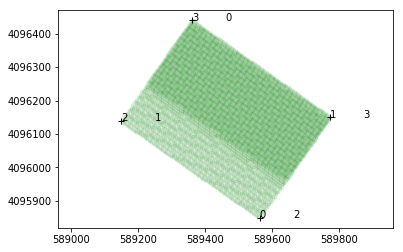

In [4]:
fig, ax = plt.subplots()
ax.plot(coords['xx'].ravel(), coords['yy'].ravel(), 'g.', alpha=0.1)
ax.axis('equal')
utm_corners = np.c_[x_corners.ravel(), y_corners.ravel()]
for i, coord in enumerate(utm_corners):
    ax.plot(coord[0], coord[1], 'k+')
    ax.text(coord[0], coord[1], str(i))
utm_corners = utm_corners[[3, 2, 0, 1]]
for i, coord in enumerate(utm_corners):
    ax.text(coord[0]+100, coord[1], str(i))

In [5]:
utm = osgeo.osr.SpatialReference()
web = osgeo.osr.SpatialReference()
wgs84 = osgeo.osr.SpatialReference()
utm.ImportFromEPSG(32629)
web.ImportFromEPSG(3857)
wgs84.ImportFromEPSG(4326)
utm2web = osgeo.osr.CoordinateTransformation(utm, web)
web2utm = osgeo.osr.CoordinateTransformation(web, utm)
utm2wgs84 = osgeo.osr.CoordinateTransformation(utm, wgs84)

In [6]:

web_corners = np.array(utm2web.TransformPoints(utm_corners))
wgs84_corners = np.array(utm2wgs84.TransformPoints(utm_corners))
ul = web_corners[:, 0].min(), web_corners[:, 1].max()
lr = web_corners[:, 0].max(), web_corners[:, 1].min()
ur = web_corners[:, 0].max(), web_corners[:, 1].max()
ll = web_corners[:, 0].min(), web_corners[:, 1].min()
projwin = "{} {} {} {}".format(ul[0], ul[1], lr[0], lr[1]) 
projwin

'-890329.7104563778 4440484.001948741 -889548.3603522603 4439739.141982423'

In [7]:
!gdal_translate -projwin $projwin -of gtiff -outsize 2048 2048 mapbox.xml mapbox.tiff
!gdal_translate -projwin $projwin -of png -outsize 2048 2048 mapbox.xml mapbox.png

Input file size is 536870912, 536870912
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 536870912, 536870912
0...10...20...30...40...50...60...70...80...90...100 - done.


In [8]:
template = '''\
<?xml version="1.0" encoding="UTF-8"?>
<kml xmlns="http://www.opengis.net/kml/2.2">
  <Placemark>
    <name>domain</name>
    <Polygon>
      <altitudeMode>relativeToGround</altitudeMode>
      <outerBoundaryIs>
        <LinearRing>
          <coordinates>
%for coord in coords:
    ${coord[0]},${coord[1]},10
%endfor
          </coordinates>
        </LinearRing>
      </outerBoundaryIs>
    </Polygon>
  </Placemark>
</kml>
'''
kml_txt = mako.template.Template(template).render(coords=wgs84_corners)
with open('domain.kml', 'w') as f:
    f.write(kml_txt)
!open domain.kml

In [9]:
src = np.array([(ul[0], ul[1]), (ll[0], ll[1]), (lr[0], lr[1]), (ur[0], ur[1])], dtype='float32')
dst = np.array([web_corners[0], web_corners[1], web_corners[2], web_corners[3]]).astype('float32')[:, :2]
img = cv2.imread('mapbox.png')


array([[ -890062.0666991 ,  4440484.00194874,        0.        ],
       [ -890329.71045638,  4440108.60438931,        0.        ],
       [ -889816.02496461,  4439739.14198242,        0.        ],
       [ -889548.36035226,  4440114.51328632,        0.        ]])

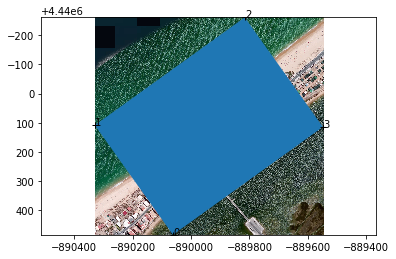

In [10]:
fig, ax = plt.subplots()
ax.imshow(img[:,:,::-1], origin='top', extent=(ul[0], ur[0], ul[1], lr[1]))
for i, coord in enumerate(web_corners):
    ax.plot(coord[0], coord[1], 'k+')
    ax.text(coord[0], coord[1], str(i))
ax.fill(dst[:,0], dst[:,1])
ax.autoscale()
ax.axis('equal')
web_corners

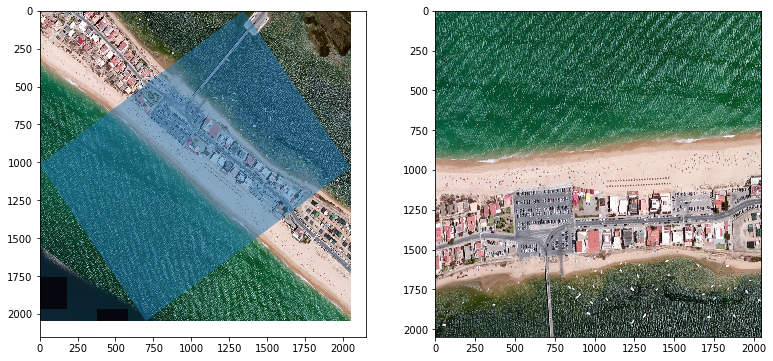

In [13]:
dst_img = (src - src.min(axis=0))/(src.max(axis=0) - src.min(axis=0)) * img.shape[:2]
src_img = (dst - src.min(axis=0))/(src.max(axis=0) - src.min(axis=0)) * img.shape[:2]
M = cv2.getPerspectiveTransform(src.astype('float32'), dst.astype('float32'))
M_img = cv2.getPerspectiveTransform(src_img.astype('float32'), dst_img.astype('float32'))
warped = cv2.warpPerspective(np.flipud(img), M_img, (800, 600))

fig, axes = plt.subplots(1,2 , figsize=(13, 6))
axes[0].imshow(img[:,:,::-1])
axes[1].imshow(warped[:,:,::-1])
src_img, dst_img
axes[0].fill(src_img[:, 0], src_img[:, 1], alpha=0.5)
plt.imsave('warped.png', warped[:, :, ::-1])

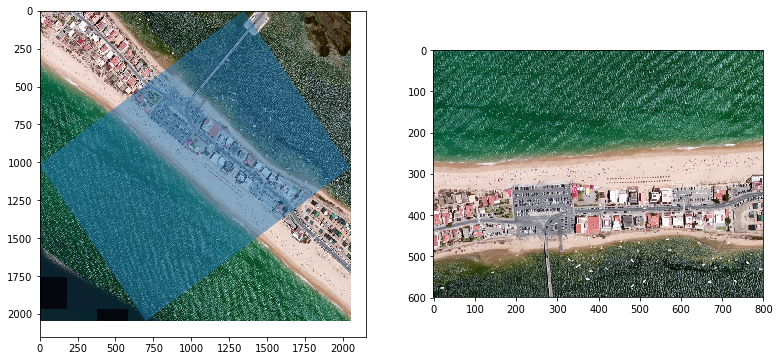

In [15]:
dst_img = (src - src.min(axis=0))/(src.max(axis=0) - src.min(axis=0)) * (800, 600)
src_img = (dst - src.min(axis=0))/(src.max(axis=0) - src.min(axis=0)) * img.shape[:2]
M = cv2.getPerspectiveTransform(src.astype('float32'), dst.astype('float32'))
M_img = cv2.getPerspectiveTransform(src_img.astype('float32'), dst_img.astype('float32'))
warped = cv2.warpPerspective(np.flipud(img), M_img, (800, 600))

fig, axes = plt.subplots(1,2 , figsize=(13, 6))
axes[0].imshow(img[:,:,::-1])
axes[1].imshow(warped[:,:,::-1])
src_img, dst_img
axes[0].fill(src_img[:, 0], src_img[:, 1], alpha=0.5)
plt.imsave('warped.png', warped[:, :, ::-1])
warped = cv2.warpPerspective(np.flipud(img), M_img, (800, 600))
plt.imsave('warped_800_600.png', warped[:, :, ::-1])